In [108]:
!pip install shap lime
import shap

In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
# Load the data
df = pd.read_csv("car_insurance_claim.csv")
df.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [111]:
# Convert monetary values to numeric by removing "$" and ","
monetary_columns = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM", "CLM_AMT"]
for col in monetary_columns:
    df[col] = df[col].replace({'\\$': '', ',': ''}, regex=True).astype(str)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [112]:
# Handle missing values: Fill numerical columns with median and categorical with mode
for col in df.select_dtypes(include=['number']).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-112-e45d0a512873>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-112-e45d0a512873>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [113]:
# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

In [114]:
df.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,OCCUPATION_z_Blue Collar,CAR_USE_Private,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,RED_CAR_yes,REVOKED_Yes,URBANICITY_z_Highly Rural/ Rural
0,0,60.0,0,11.0,67349.0,0.0,14,14230,11,4461,...,False,True,False,False,False,False,False,True,False,False
1,0,43.0,0,11.0,91449.0,257252.0,22,14940,1,0,...,True,False,False,False,False,False,False,True,False,False
2,0,48.0,0,11.0,52881.0,0.0,26,21970,1,0,...,False,True,False,False,False,True,False,True,False,False
3,0,35.0,1,10.0,16039.0,124191.0,5,4010,4,38690,...,False,True,False,False,False,False,True,False,False,False
4,0,51.0,0,14.0,53529.0,306251.0,32,15440,7,0,...,True,True,False,False,False,False,False,True,False,False


In [115]:
# Define target variables
X = df.drop(columns=["CLAIM_FLAG", "CLM_AMT"])  # Features
y_classification = df["CLAIM_FLAG"]  # Classification target
y_regression = df["CLM_AMT"]  # Regression target

In [116]:
# Data spliting
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg = train_test_split(
    X, y_classification, y_regression, test_size=0.2, random_state=42)

In [117]:
# Scale the feature sets
scaler_cls = StandardScaler()
scaler_reg = StandardScaler()

# Scale classification data
X_train_cls_scaled = scaler_cls.fit_transform(X_train)
X_test_cls_scaled = scaler_cls.transform(X_test)

# Scale regression data
X_train_reg_scaled = scaler_reg.fit_transform(X_train)
X_test_reg_scaled = scaler_reg.transform(X_test)

In [118]:
# Train RandomForest models on scaled data
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train_cls_scaled, y_train_cls)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg_scaled, y_train_reg)

RandomForestRegressor(random_state=42)

In [119]:
# Predictions
y_pred_cls = rf_cls.predict(X_test_cls_scaled)
y_prob_cls = rf_cls.predict_proba(X_test_cls_scaled)[:, 1]
y_pred_reg = rf_reg.predict(X_test_reg_scaled)

print("Classification Predictions:", y_pred_cls)
print("Regression Predictions:", y_pred_reg)

Classification Predictions: [0 1 0 ... 0 0 0]
Regression Predictions: [ 908.53 2479.74 2543.19 ... 1653.15 1562.44  129.44]


In [120]:
# Classification Performance Metrics
classification_results = {
    "Accuracy": accuracy_score(y_test_cls, y_pred_cls),
    "AUC": roc_auc_score(y_test_cls, y_prob_cls),
    "Classification Report": classification_report(y_test_cls, y_pred_cls, output_dict=True)
}

print("\n=== Classification Results ===")
print(f"Accuracy: {classification_results['Accuracy']:.4f}")
print(f"AUC: {classification_results['AUC']:.4f}")

# Print Classification Report
report = classification_report(y_test_cls, y_pred_cls)
print("\nClassification Report:\n", report)

# Regression Performance Metrics
regression_results = {
    "MAE": mean_absolute_error(y_test_reg, y_pred_reg),
    "MSE": mean_squared_error(y_test_reg, y_pred_reg),
    "RMSE": np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
}

print("\n=== Regression Results ===")
print(f"Mean Absolute Error (MAE): {regression_results['MAE']:.2f}")
print(f"Mean Squared Error (MSE): {regression_results['MSE']:.2f}")
print(f"Root Mean Squared Error (RMSE): {regression_results['RMSE']:.2f}")


=== Classification Results ===
Accuracy: 0.7865
AUC: 0.8034

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.87      1506
           1       0.70      0.37      0.48       555

    accuracy                           0.79      2061
   macro avg       0.75      0.65      0.67      2061
weighted avg       0.77      0.79      0.76      2061


=== Regression Results ===
Mean Absolute Error (MAE): 1989.22
Mean Squared Error (MSE): 16366987.83
Root Mean Squared Error (RMSE): 4045.61


**Accounting Sensitive Data**

In [121]:
# Feature importance analysis
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance_Classification": rf_cls.feature_importances_,
    "Importance_Regression": rf_reg.feature_importances_
}).sort_values(by=["Importance_Classification", "Importance_Regression"], ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


Top 10 Important Features:
     Feature  Importance_Classification  Importance_Regression
4     INCOME                   0.085706               0.084920
7   BLUEBOOK                   0.085573               0.128545
1        AGE                   0.076475               0.084096
6   TRAVTIME                   0.074203               0.074999
5   HOME_VAL                   0.072641               0.072725
9   OLDCLAIM                   0.071505               0.097913
11   MVR_PTS                   0.053840               0.048773
12   CAR_AGE                   0.051429               0.043758
3        YOJ                   0.048491               0.046000
8        TIF                   0.045820               0.041805


In [122]:
# Remove less important features (based on importance)
selected_features = feature_importance_df["Feature"][:10]  # Keep top 10 features
X_train_cls_selected = X_train[selected_features].drop(columns=["INCOME","HOME_VAL"])
X_test_cls_selected = X_test[selected_features].drop(columns=["INCOME","HOME_VAL"])
X_train_reg_selected = X_train[selected_features].drop(columns=["INCOME","HOME_VAL"])
X_test_reg_selected = X_test[selected_features].drop(columns=["INCOME","HOME_VAL"])

In [123]:
# Scale the feature sets
scaler_cls_selected = StandardScaler()
scaler_reg_selected = StandardScaler()

# Scale classification data
X_train_cls_selected_scaled = scaler_cls_selected.fit_transform(X_train_cls_selected)
X_test_cls_selected_scaled = scaler_cls_selected.transform(X_test_cls_selected)

# Scale regression data
X_train_reg_selected_scaled = scaler_reg_selected.fit_transform(X_train_reg_selected)
X_test_reg_selected_scaled = scaler_reg_selected.transform(X_test_reg_selected)

In [124]:
# Train RandomForest models on scaled data
rf_cls_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls_selected.fit(X_train_cls_selected_scaled, y_train_cls)

rf_reg_selected = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_selected.fit(X_train_reg_selected_scaled, y_train_reg)

RandomForestRegressor(random_state=42)

In [125]:
# Predictions
y_pred_cls_selected = rf_cls_selected.predict(X_test_cls_selected_scaled)
y_prob_cls_selected = rf_cls_selected.predict_proba(X_test_cls_selected_scaled)[:, 1]
y_pred_reg_selected = rf_reg_selected.predict(X_test_reg_selected_scaled)

print("Classification Predictions:", y_pred_cls_selected)
print("Regression Predictions:", y_pred_reg_selected)

Classification Predictions: [0 0 1 ... 0 0 0]
Regression Predictions: [2216.6  1709.14 2477.58 ...  358.68 1097.51 1180.29]


In [126]:
# Classification Performance Metrics
classification_results_selected = {
    "Accuracy": accuracy_score(y_test_cls, y_pred_cls_selected),
    "AUC": roc_auc_score(y_test_cls, y_prob_cls_selected),
    "Classification Report": classification_report(y_test_cls, y_pred_cls_selected, output_dict=True)
}

# Print Classification Report
print("\n=== Classification Results (Selected Features) ===")
print(f"Accuracy: {classification_results_selected['Accuracy']:.4f}")
print(f"AUC: {classification_results_selected['AUC']:.4f}")
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls_selected))

# Regression Performance Metrics
regression_results_selected = {
    "MAE": mean_absolute_error(y_test_reg, y_pred_reg_selected),
    "MSE": mean_squared_error(y_test_reg, y_pred_reg_selected),
    "RMSE": np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_selected))
}

print("\n=== Regression Results (Selected Features) ===")
print(f"Mean Absolute Error (MAE): {regression_results_selected['MAE']:.2f}")
print(f"Mean Squared Error (MSE): {regression_results_selected['MSE']:.2f}")
print(f"Root Mean Squared Error (RMSE): {regression_results_selected['RMSE']:.2f}")


=== Classification Results (Selected Features) ===
Accuracy: 0.7472
AUC: 0.7117

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1506
           1       0.57      0.25      0.35       555

    accuracy                           0.75      2061
   macro avg       0.67      0.59      0.60      2061
weighted avg       0.72      0.75      0.71      2061


=== Regression Results (Selected Features) ===
Mean Absolute Error (MAE): 2185.76
Mean Squared Error (MSE): 17574703.15
Root Mean Squared Error (RMSE): 4192.22


# Update 2a_SHAP

In [127]:
feature_names = X.columns.tolist()

<Figure size 2000x400 with 0 Axes>

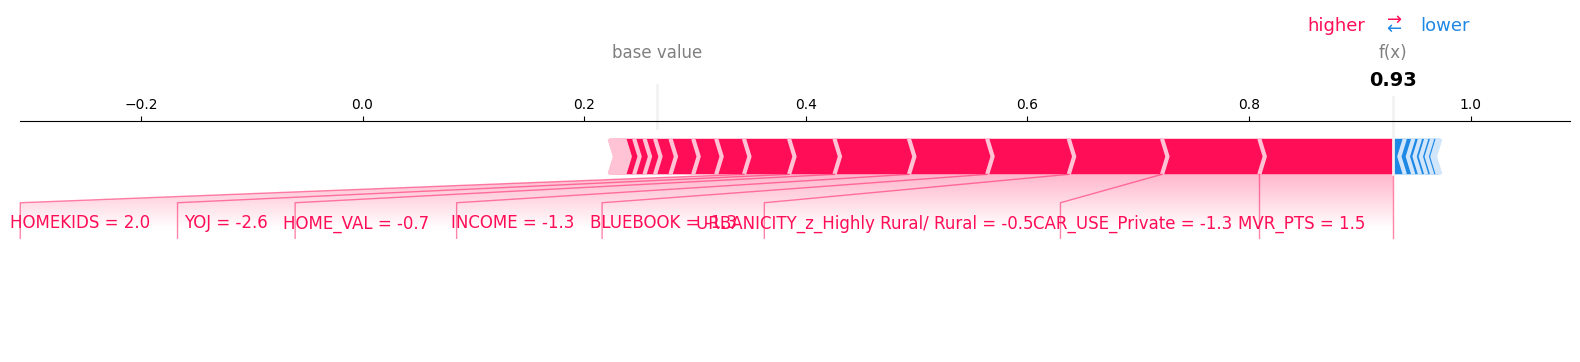

In [145]:
#SHAP Analysis for Classification# Force plot for a single prediction

sample_proba = rf_cls.predict_proba(X_test_cls_scaled)[:, 1]
high_prob_idx = np.argsort(sample_proba)[-1]

explainer_cls = shap.TreeExplainer(rf_cls, feature_perturbation="tree_path_dependent")

# Get SHAP values for that sample
shap_values_high_prob_raw = explainer_cls.shap_values(X_test_cls_scaled[high_prob_idx:high_prob_idx+1])

# Convert to list of arrays if needed
if isinstance(shap_values_high_prob_raw, np.ndarray) and shap_values_high_prob_raw.ndim == 3:
    shap_values_high_prob = [shap_values_high_prob_raw[:, :, i] for i in range(shap_values_high_prob_raw.shape[2])]
else:
    shap_values_high_prob = shap_values_high_prob_raw

# Extract values for positive class (1)
shap_values_high_prob_class1 = shap_values_high_prob[1]

# Input data for that sample
X_high_prob_df = pd.DataFrame(X_test_cls_scaled[high_prob_idx:high_prob_idx+1], columns=feature_names)

# Display interactive SHAP force plot
plt.figure(figsize=(20, 4))
X_high_prob_df_rounded = X_high_prob_df.round(1)
shap.force_plot(
    explainer_cls.expected_value[1],
    shap_values_high_prob_class1,
    X_high_prob_df_rounded,
    matplotlib=True,
    show=True
)


=== SHAP Analysis for Regression Model ===


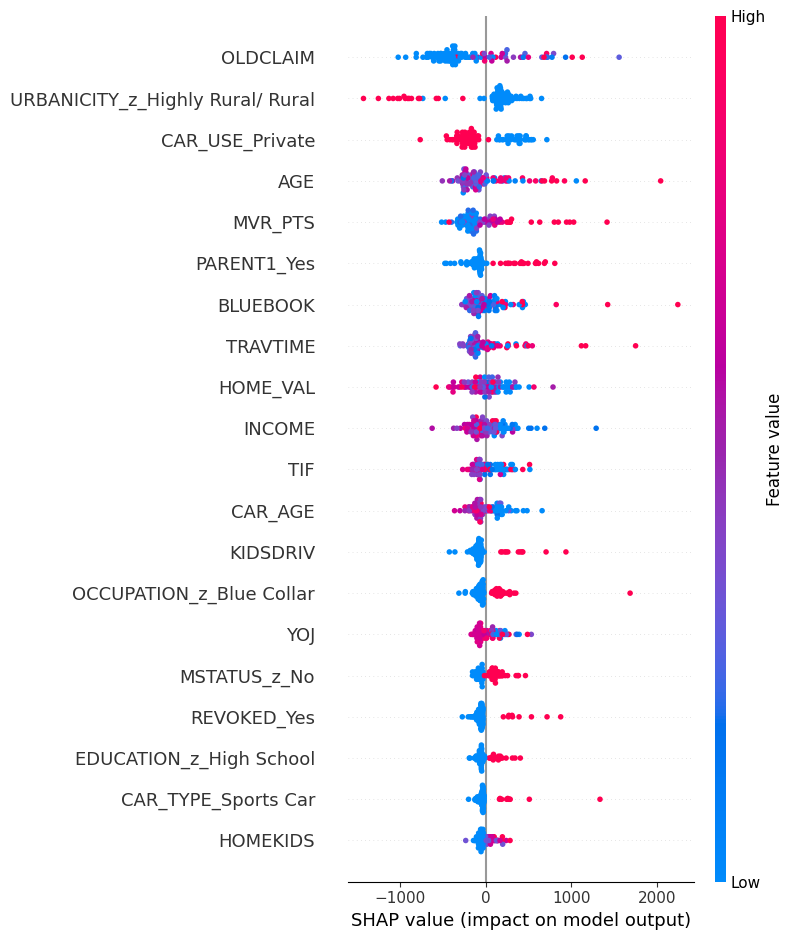

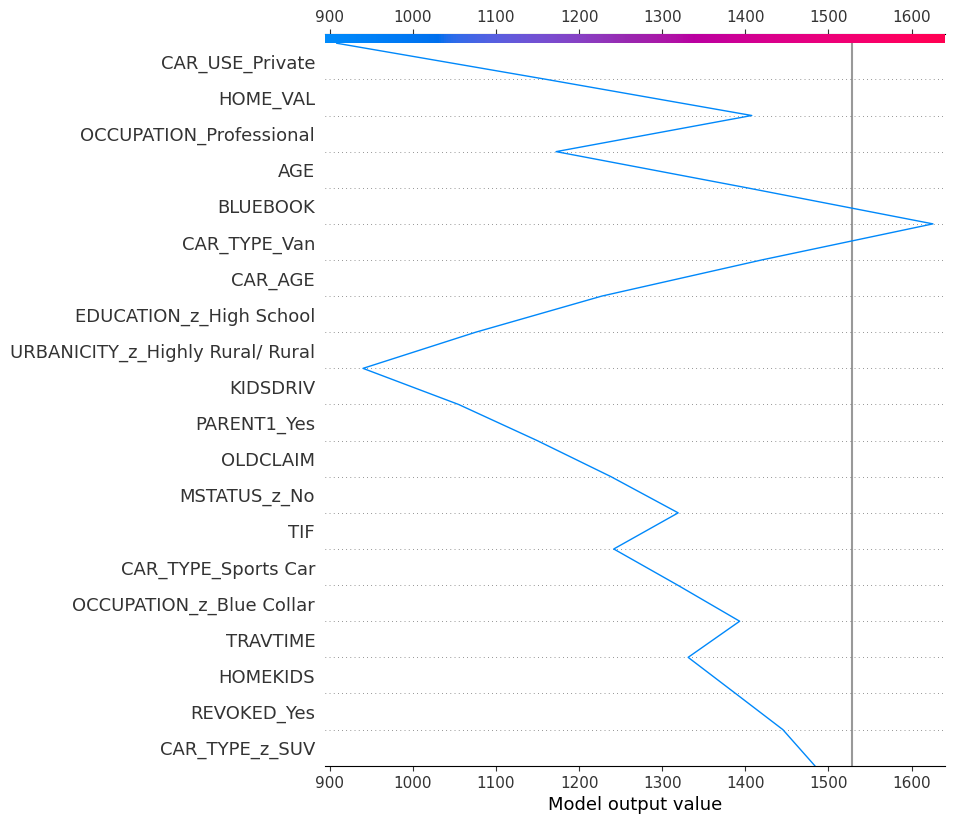

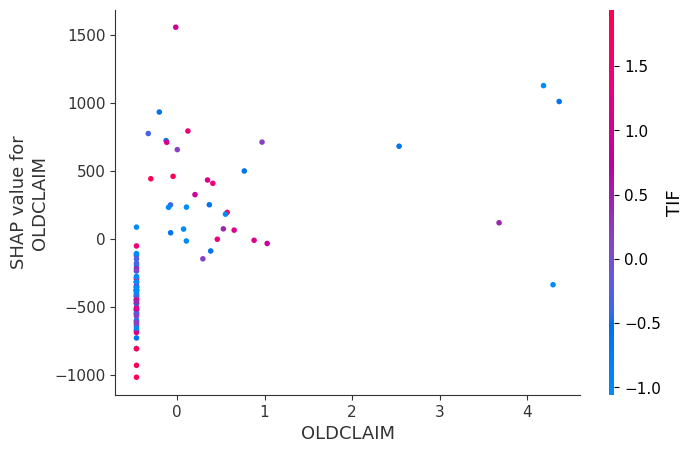

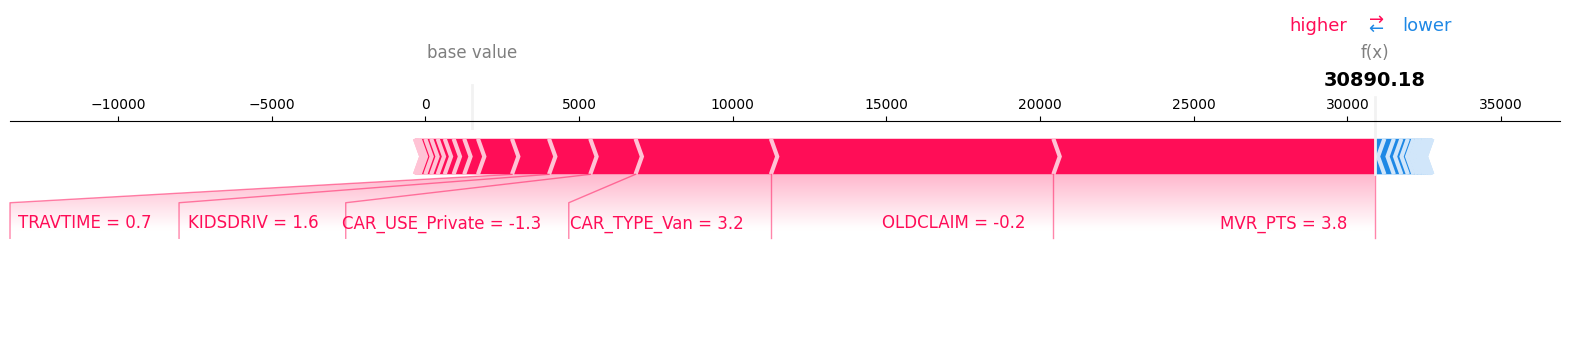

In [146]:
# SHAP Analysis for Regression Model

print("\n=== SHAP Analysis for Regression Model ===")

# Initialize the SHAP explainer for regression
explainer_reg = shap.TreeExplainer(rf_reg)

# Sample data for SHAP analysis
X_sample_reg = X_test_reg_scaled[:100]

# Calculate SHAP values
shap_values_reg = explainer_reg.shap_values(X_sample_reg)

# Summary Plot
shap.summary_plot(shap_values_reg, X_sample_reg, feature_names=feature_names)

# SHAP Decision Plot
sample_idx = 0
shap.decision_plot(explainer_reg.expected_value, shap_values_reg[sample_idx],
                   feature_names=feature_names, show=True)

# SHAP Dependence Plot for top feature
top_feature_idx_reg = np.argmax(np.mean(np.abs(shap_values_reg), axis=0))
top_feature_reg = feature_names[top_feature_idx_reg]
shap.dependence_plot(top_feature_idx_reg, shap_values_reg, X_sample_reg,
                     feature_names=feature_names, show=True)

# Force plot for a single prediction
sample_pred = rf_reg.predict(X_test_reg_scaled)
high_pred_idx = np.argmax(sample_pred)
shap_values_high_pred = explainer_reg.shap_values(X_test_reg_scaled[high_pred_idx:high_pred_idx+1])

plt.rcParams['figure.figsize'] = (25, 3)

# Round feature values for cleaner labels
X_high_pred_df = pd.DataFrame(X_test_reg_scaled[high_pred_idx:high_pred_idx+1], columns=feature_names)
X_high_pred_df_rounded = X_high_pred_df.round(1)

# Display SHAP force plot using matplotlib
shap.force_plot(
    explainer_reg.expected_value,
    shap_values_high_pred,
    X_high_pred_df_rounded,
    matplotlib=True,
    show=True
)


=== SHAP Analysis for Models with Selected Features ===


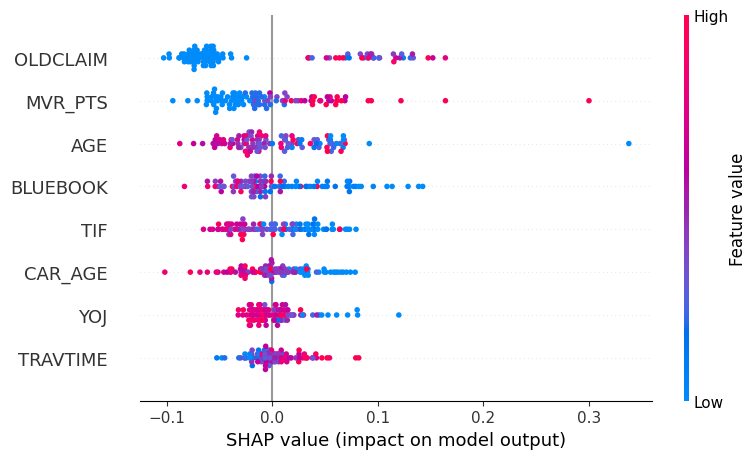

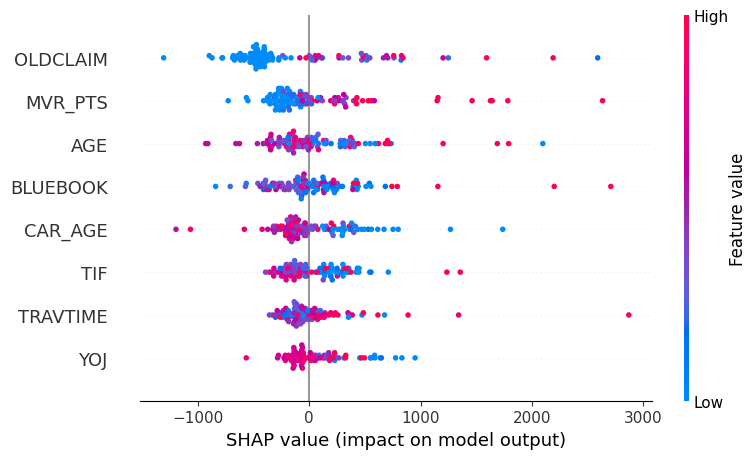

In [130]:
# SHAP Analysis for Models with Selected Features

print("\n=== SHAP Analysis for Models with Selected Features ===")

# SHAP Analysis for Selected Feature Classification Model
explainer_cls_selected = shap.TreeExplainer(rf_cls_selected)
X_sample_cls_selected = X_test_cls_selected_scaled[:100]
shap_values_cls_selected = explainer_cls_selected.shap_values(X_sample_cls_selected)

# For multi-class: convert 3D array to list of 2D arrays (one per class)
if isinstance(shap_values_cls_selected, np.ndarray) and shap_values_cls_selected.ndim == 3:
    shap_values_cls_selected = [shap_values_cls_selected[:, :, i] for i in range(shap_values_cls_selected.shape[2])]

# Summary Plot for Selected Features Classification
selected_feature_names = X_train_cls_selected.columns.tolist()
shap.summary_plot(shap_values_cls_selected[1], X_sample_cls_selected,
                  feature_names=selected_feature_names, show=True)

# SHAP Analysis for Selected Feature Regression Model
explainer_reg_selected = shap.TreeExplainer(rf_reg_selected)
X_sample_reg_selected = X_test_reg_selected_scaled[:100]
shap_values_reg_selected = explainer_reg_selected.shap_values(X_sample_reg_selected)

# Summary Plot for Selected Features Regression
shap.summary_plot(shap_values_reg_selected, X_sample_reg_selected,
                  feature_names=selected_feature_names, show=True)



=== Feature Importance Comparison: Random Forest vs SHAP (Selected Features) ===


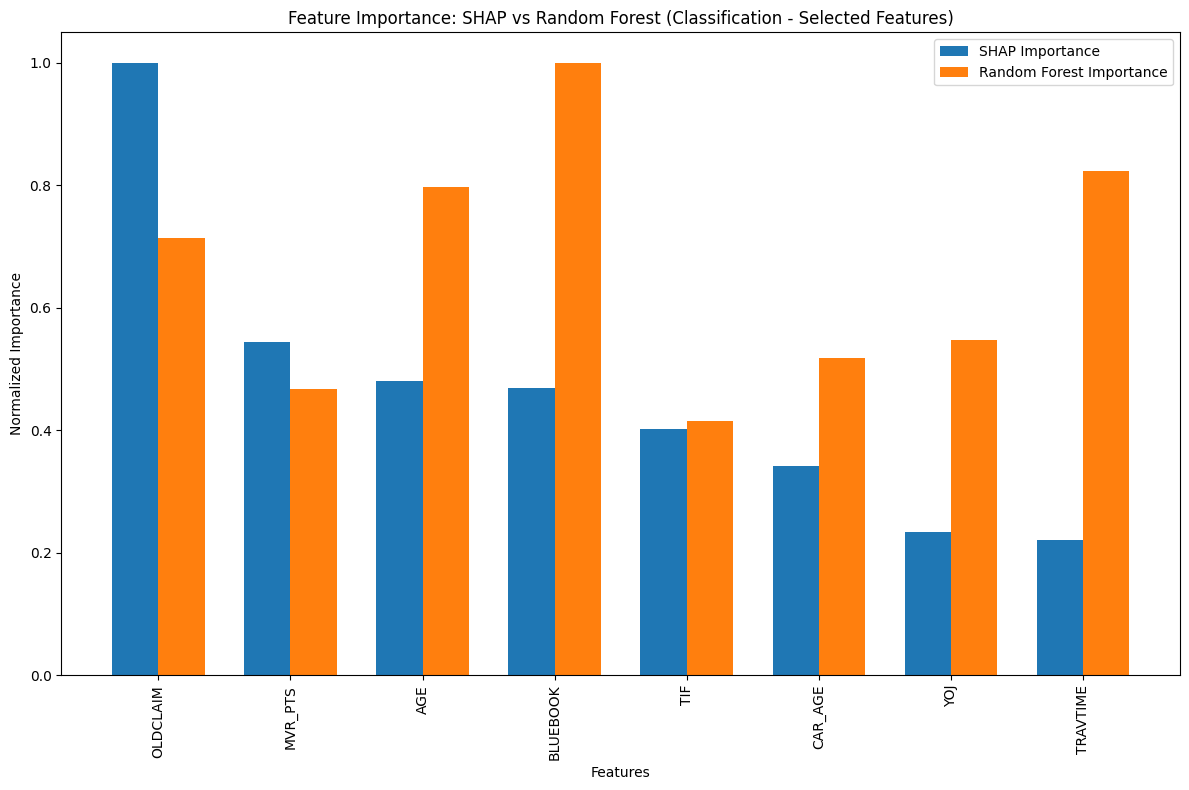

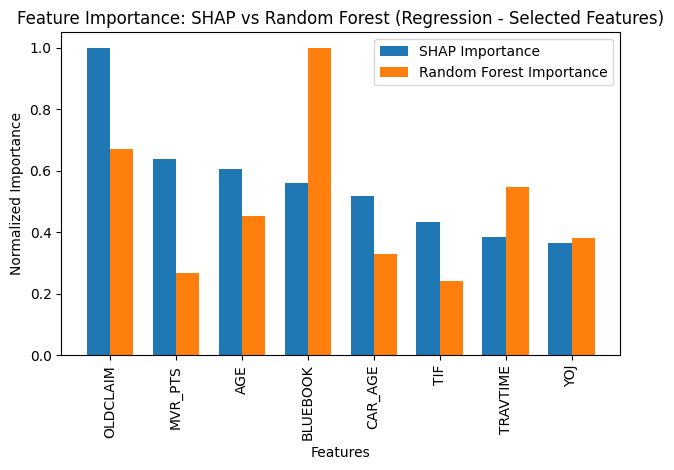

In [131]:
# Feature Importance Comparison: Random Forest vs SHAP (Selected Features)
#################################################
print("\n=== Feature Importance Comparison: Random Forest vs SHAP (Selected Features) ===")

# Classification Feature Importance Comparison (Selected Features)
shap_importance_cls_sel = pd.DataFrame({
    'Feature': selected_feature_names,
    'SHAP_Importance': np.mean(np.abs(shap_values_cls_selected[1]), axis=0)
})
rf_importance_cls_sel = pd.DataFrame({
    'Feature': selected_feature_names,
    'RF_Importance': rf_cls_selected.feature_importances_
})

comparison_cls_sel = pd.merge(shap_importance_cls_sel, rf_importance_cls_sel, on='Feature')
comparison_cls_sel = comparison_cls_sel.sort_values('SHAP_Importance', ascending=False)

comparison_cls_sel['SHAP_Importance_Norm'] = comparison_cls_sel['SHAP_Importance'] / comparison_cls_sel['SHAP_Importance'].max()
comparison_cls_sel['RF_Importance_Norm'] = comparison_cls_sel['RF_Importance'] / comparison_cls_sel['RF_Importance'].max()

# Plot Classification Comparison (Selected Features)
top_n = 15
comparison_top_cls = comparison_cls_sel.head(top_n)

x = np.arange(len(comparison_top_cls))
width = 0.35

plt.figure(figsize=(12, 8))
plt.bar(x - width/2, comparison_top_cls['SHAP_Importance_Norm'], width, label='SHAP Importance')
plt.bar(x + width/2, comparison_top_cls['RF_Importance_Norm'], width, label='Random Forest Importance')

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance: SHAP vs Random Forest (Classification - Selected Features)')
plt.xticks(x, comparison_top_cls['Feature'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Regression Feature Importance Comparison (Selected Features)
shap_importance_reg_sel = pd.DataFrame({
    'Feature': selected_feature_names,
    'SHAP_Importance': np.mean(np.abs(shap_values_reg_selected), axis=0)
})
rf_importance_reg_sel = pd.DataFrame({
    'Feature': selected_feature_names,
    'RF_Importance': rf_reg_selected.feature_importances_
})

comparison_reg_sel = pd.merge(shap_importance_reg_sel, rf_importance_reg_sel, on='Feature')
comparison_reg_sel = comparison_reg_sel.sort_values('SHAP_Importance', ascending=False)

comparison_reg_sel['SHAP_Importance_Norm'] = comparison_reg_sel['SHAP_Importance'] / comparison_reg_sel['SHAP_Importance'].max()
comparison_reg_sel['RF_Importance_Norm'] = comparison_reg_sel['RF_Importance'] / comparison_reg_sel['RF_Importance'].max()

# Plot Regression Comparison (Selected Features)
comparison_top_reg = comparison_reg_sel.head(top_n)

x = np.arange(len(comparison_top_reg))

plt.bar(x - width/2, comparison_top_reg['SHAP_Importance_Norm'], width, label='SHAP Importance')
plt.bar(x + width/2, comparison_top_reg['RF_Importance_Norm'], width, label='Random Forest Importance')

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance: SHAP vs Random Forest (Regression - Selected Features)')
plt.xticks(x, comparison_top_reg['Feature'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


# **Update 2a_DiCE**

In [132]:
# !pip install --upgrade --force-reinstall \
#   numpy==1.24.3 \
#   pandas==2.2.2 \
#   scikit-learn==1.2.2 \
#  shap \
#   dice-ml

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score, mean_absolute_error, mean_squared_error, r2_score)
import warnings
import dice_ml
from dice_ml.utils import helpers

In [134]:
# DiCE Counterfactual Explanations
# Prepare data for DiCE
X_train_dice, X_test_dice, y_train_dice, y_test_dice = train_test_split(X, y_classification, test_size=0.2, random_state=0)

for column in X_train_dice.select_dtypes(include=['object','category']).columns:
    X_train_dice[column] = pd.to_numeric(X_train_dice[column], errors='coerce')
    X_test_dice[column] = pd.to_numeric(X_test_dice[column], errors='coerce')

for column in X_train_dice.select_dtypes(include=['bool']).columns:
    X_train_dice[column] = X_train_dice[column].astype(int)
    X_test_dice[column] = X_test_dice[column].astype(int)

# Create DiCE data object
d = dice_ml.Data(dataframe=pd.concat([X_train_dice, y_train_dice], axis=1),
                 continuous_features=X_train_dice.columns.tolist(),
                 outcome_name='CLAIM_FLAG')

# Create DiCE model
m = dice_ml.Model(model=RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_dice, y_train_dice),
                 backend='sklearn')

# Create DiCE explainer
exp = dice_ml.Dice(d, m)


# Find an instance with CLAIM_FLAG=0 to generate counterfactuals
query_instance = X_test_dice[y_test_dice == 0].iloc[[0]]  # Pick one 'CLAIM_FLAG=0'

# Generate counterfactuals
print("Generating counterfactuals for a 'No Claim' instance...")
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")

# Display original instance
print("\nOriginal instance (No Claim):")
display(query_instance)

# Display counterfactuals
print("\nCounterfactual instances to Claim:")
display(dice_exp.visualize_as_dataframe(show_only_changes=True))

Generating counterfactuals for a 'No Claim' instance...


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Original instance (No Claim):


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,OCCUPATION_z_Blue Collar,CAR_USE_Private,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,RED_CAR_yes,REVOKED_Yes,URBANICITY_z_Highly Rural/ Rural
9827,2,41.0,2,13.0,53529.0,283152.0,27,14260,3,3712,...,1,0,0,0,0,0,1,0,0,0



Counterfactual instances to Claim:
Query instance (original outcome : 0)


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,CAR_USE_Private,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,RED_CAR_yes,REVOKED_Yes,URBANICITY_z_Highly Rural/ Rural,CLAIM_FLAG
0,2,41.0,2,13.0,53529.0,283152.0,27,14260,3,3712,...,0,0,0,0,0,1,0,0,0,0



Diverse Counterfactual set (new outcome: 1.0)


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,CAR_USE_Private,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,RED_CAR_yes,REVOKED_Yes,URBANICITY_z_Highly Rural/ Rural,CLAIM_FLAG
0,-,71.4,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,0.0,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1.0,-,1.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1.0,-,1.0


None

In [135]:
# Create a counterfacuals analysis to determine the comparisons
def analyze_counterfactuals(original, counterfactuals):
    """
    Analyze changes in counterfactuals with more detailed comparison

    Args:
        original (pd.DataFrame): Original data instance
        counterfactuals (object): DiCE counterfactual explanations
    """
    # Extract counterfactual dataframe
    cf_df = counterfactuals.cf_examples_list[0].final_cfs_df

    # Original instance values
    original_values = original.iloc[0]

    # Track significant changes
    significant_changes = {}

    # Iterate through counterfactuals
    for i, row in cf_df.iterrows():
        print(f"\nCounterfactual #{i+1} Analysis:")

        # Compare each feature
        for column in original.columns:
            if column in row and row[column] != original_values[column]:
                # Numeric features
                if isinstance(original_values[column], (int, float)):
                    change_pct = abs((row[column] - original_values[column]) / original_values[column]) * 100

                    print(f"  - {column}:")
                    print(f"    Original: {original_values[column]:.2f}")
                    print(f"    Changed to: {row[column]:.2f}")
                    print(f"    Absolute Change: {row[column] - original_values[column]:+.2f}")
                    print(f"    Percentage Change: {change_pct:.2f}%")

                    # Store significant changes (>10% change)
                    if change_pct > 10:
                        significant_changes[column] = {
                            'original': original_values[column],
                            'new': row[column],
                            'change_pct': change_pct
                        }

                # Categorical features
                else:
                    print(f"  - {column}: {original_values[column]} → {row[column]}")

        # Highlight significant changes
        if significant_changes:
            print("\nMost Significant Changes:")
            for feat, details in significant_changes.items():
                print(f"  - {feat}: {details['original']} → {details['new']} ({details['change_pct']:.2f}% change)")

In [136]:
analyze_counterfactuals(query_instance, dice_exp)


Counterfactual #1 Analysis:
  - AGE:
    Original: 41.00
    Changed to: 71.40
    Absolute Change: +30.40
    Percentage Change: 74.15%
  - MVR_PTS:
    Original: 3.00
    Changed to: 11.00
    Absolute Change: +8.00
    Percentage Change: 266.67%

Most Significant Changes:
  - AGE: 41.0 → 71.4 (74.15% change)
  - MVR_PTS: 3.0 → 11.0 (266.67% change)

Counterfactual #2 Analysis:
  - CLM_FREQ:
    Original: 1.00
    Changed to: 4.00
    Absolute Change: +3.00
    Percentage Change: 300.00%
  - MVR_PTS:
    Original: 3.00
    Changed to: 10.00
    Absolute Change: +7.00
    Percentage Change: 233.33%

Most Significant Changes:
  - AGE: 41.0 → 71.4 (74.15% change)
  - MVR_PTS: 3.0 → 10.0 (233.33% change)
  - CLM_FREQ: 1.0 → 4.0 (300.00% change)

Counterfactual #3 Analysis:
  - HOMEKIDS:
    Original: 2.00
    Changed to: 0.00
    Absolute Change: -2.00
    Percentage Change: 100.00%
  - REVOKED_Yes:
    Original: 0.00
    Changed to: 1.00
    Absolute Change: +1.00
    Percentage Change

<ipython-input-135-3a3e378b5897>:28: RuntimeWarning: divide by zero encountered in scalar divide
  change_pct = abs((row[column] - original_values[column]) / original_values[column]) * 100
